## Use OpenMM to Verify Your MM Functional Form Implementation

Recently, there have been efforts where MM functional forms are implemented within machine learning packages using tensor-accelerating framework to assist the differentiable parametrization of force fields, such as [Espaloma](https://github.com/choderalab/espaloma), [JAX-MD](https://github.com/jax-md/jax-md), and [TimeMachine](https://github.com/proteneer/timemachine/tree/master).
When you implement your own MM functional forms, you might want to make sure that they match what are used in, say, OpenMM, exactly.
Since the nonbonded part of the energy requires a lot more love to implement exactly, in this tutorial we first show you how to check your bonded energy implementation.

For simplicity, we only work with small molecules for now, which means that we would need to import `openff.toolkit` for chemoinformatics modeling.

In [238]:
import numpy as np
import openmm
from openff.toolkit.topology import Molecule

### Get a Toy Water Molecule System

We use a water molecule to focus first on bonds and angles.

In [150]:
molecule = Molecule.from_smiles("[H]O[H]")

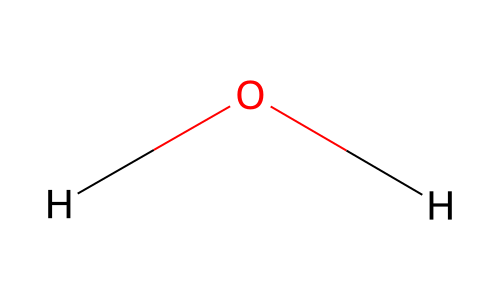

In [151]:
molecule.visualize()

It's also worth noting the index-element correspondance in this molecule, where the 0th and 2nd atoms are hydrogens whereas the 1st is oxygen.

In [152]:
molecule.atoms

[Atom(name=, atomic number=1),
 Atom(name=, atomic number=8),
 Atom(name=, atomic number=1)]

To create OpenMM systems, we use an OpenFF force field.

In [153]:
from openff.toolkit.typing.engines.smirnoff import ForceField
forcefield = ForceField("openff_unconstrained-1.2.0.offxml")

In [154]:
molecule.assign_partial_charges("mmff94")
system = forcefield.create_openmm_system(molecule.to_topology(), charge_from_molecules=[molecule])
topology = molecule.to_topology().to_openmm()

/Users/wangy1/miniconda3/envs/malt/lib/python3.10/site-packages/openff/interchange/components/interchange.py:339: UserWarning: Automatically up-converting BondHandler from version 0.3 to 0.4. Consider manually upgrading this BondHandler (or <Bonds> section in an OFFXML file) to 0.4 or newer. For more details, see https://openforcefield.github.io/standards/standards/smirnoff/#bonds.
  warnings.warn(


### Get Energy Components with OpenMM

Querying the energy contributions from OpenMM is somewhat non-intuitive.
We would need to set different force groups first.

In [155]:
for idx, force in enumerate(system.getForces()):
    force.setForceGroup(idx)

Next, we create a simulation so that we can inspect each energy component.

In [156]:
integrator = openmm.VerletIntegrator(0.0)
simulation = openmm.app.Simulation(topology,system, integrator)

Let's also set the initial positions to one of the conformations of the water molecule.

In [157]:
molecule.generate_conformers() # generate molecule conformers

# NOTE:
# OpenMM and OpenFF use two sets of unit systems,
# hence the awkward conversion
simulation.context.setPositions(
    openmm.unit.nanometer * molecule._conformers[0].magnitude,
)

In [162]:
for idx, force in enumerate(system.getForces()):
    state = simulation.context.getState(getEnergy=True, groups={idx})
    if "HarmonicBondForce" in force.getName():
        bond_energy = state.getPotentialEnergy()
    if "HarmonicAngleForce" in force.getName():
        angle_energy = state.getPotentialEnergy()

print("Bond Energy", bond_energy)
print("Angle Energy", angle_energy)

Bond Energy 368275.4375 kJ/mol
Angle Energy 1.3650074005126953 kJ/mol


### Implement our own distance and angle functions
Here we show a very simple example.
This is usually done in an elaborate tensor-accelerating framework.

The bond length can be computed as the root of the squared difference between two bonded atoms.

In [166]:
def get_distance_vector(x0, x1):
    return x1 - x0

In [194]:
def get_norm(x01):
    return np.linalg.norm(x01, ord=2, axis=-1)

In [195]:
def get_distance(x0, x1):
    return get_norm(get_distance_vector(x0, x1))

In [208]:
def get_angle(x0, x1, x2):
    x10 = get_distance_vector(x1, x0)
    x12 = get_distance_vector(x1, x2)
    c012 = np.arctan2(
        get_norm(np.cross(x10, x12)),
        (x10 * x12).sum(-1)
    )
    return c012

### Implement our own MM forces

Let's implement harmonic bond and angle forces from scratch:

In [209]:
def harmonic(x, k, r0):
    return 0.5 * k * (x - r0) ** 2

### Compute angle and bond energy

One of the nice things about OpenMM is that it works with units, whereas most tensor-accelerating frameworks don't.
Here our crappy implementation doesn't take care of units either.
So we work with numeric values only---everything has the default of OpenMM units: `nanometer` for distances, `radian` for angles, and `kJ/mol` for energies.

We first compute the bonds and angles using the functions defined above.

In [210]:
conformer = molecule._conformers[0].magnitude
x0, x1, x2 = conformer

In [227]:
r01 = get_distance(x0, x1)
r12 = get_distance(x1, x2)

In [214]:
c012 = get_angle(x0, x1, x2)

Then we grab the parameters: bond equilibrium length `r0`, bond force constant `k_r`, equilibrium angle `theta_0`, angle force constant `k_theta`, from the OpenMM `System`.
Note that here we know that there is only one kind of bond and one kind of angle, saving us the need for bookkeeping.
In real life one would need to carefully manage bond and angle types.

In [230]:
for force in system.getForces():
    if "HarmonicBond" in force.getName():
        _, __, r0, k_r = force.getBondParameters(0)
    if "HarmonicAngle" in force.getName():
        _, __, ___, theta0, k_theta = force.getAngleParameters(0)

We have to erase the units, unfortunately.

In [231]:
r0, k_r, theta0, k_theta = r0._value, k_r._value, theta0._value, k_theta._value

In [239]:
bond_energy_computed = harmonic(r01, k_r, r0) + harmonic(r12, k_r, r0)
bond_energy_computed

368275.4577602855

In [240]:
angle_energy_computed = harmonic(c012, k_theta, theta0)
angle_energy_computed

1.3650163207594144

### Check consistency

In [246]:
assert np.allclose(bond_energy_computed, bond_energy._value)
assert np.allclose(angle_energy_computed, angle_energy._value)

### Postlude
Here we have only checked the _bond_ and _angle_ energy consistency for _one_ molecule with _one_ type of bond and angle each.
But with the help of careful index matching and bookkeeping with `PyTree` containers, we are able to scale things up dramatically to check the consistency for other terms among considerable chemical and conformational spaces.
Check out unit tests [here](https://github.com/choderalab/espaloma/blob/master/espaloma/mm/tests/test_openmm_consistency.py) to see how this is done.